SUMMARY 2 

#DATA ANALYSIS#

To do all the analysis, we create a class of object called **Graph** that store the graph network of investment managers & its companies, the graphs modeled from the JSON file and/or from the data retrieved in the previous Data processing step. This object also contain all the methods to retrieve essential information of the network of concern, ex: density, degree, degree of centrality,ect.. 

To create the object: 
- take data dictionary from JSON file (not compulsory) , can also take data dictionary from *YearlyFiling13F* object
- create graph object by networkX

This object has below important attributes:
- graph: networkX graph object
- number_of_nodes
- number_of_edges
- company_nodes
- manager_nodes 
- density

This object has below important function: 
- degree()
- shared_partition_nodes()
- diff_partition_nodes()
- degreeCentralityM()
- degreeCentralityC()
- closenessCentralityM()
- closenessCentralityC()
- betweennessCentralityM()
- betweennessCentralityC()

In [54]:
# Note: remove unneccessary package, i do not have time to go over it
import requests
import operator
import glob
import re
import csv
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
from itertools import combinations 

#
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [55]:
# Get file for Json folder
def jsonToFile (listOfJsonFile):
    listOfFile = []
    for file in listOfJsonFile:
        with open(file) as json_file:
            listOfFile.append(json.load(json_file))
    return listOfFile

In [56]:
data = jsonToFile(glob.glob("json/data*.json"))
name = jsonToFile(glob.glob("json/name*.json"))

In [57]:
class Graph:
    """ 
        Class represent a graph object of 10 most popular invest managers with their company 
        and the stock amount a company’s shares held by each invest managers (shareholders)
        1.  Retrieves quarterly SEC 13F-HR filings from SEC Edgar database.
        2.  Creates a 'self.data_recent' DataFrame which contains the absolute 
            and relative changes in amount of shares and portfolio weigth 
            (with respect to the reported total portfolio value) since the last filing.
        3.  Creates a 'self.data_recent_additions' DataFrame with the additions 
            in amount of shares since the last filing.
        4.  Visualizations using 'self.plot_recent_shares_change(df)' 
            and 'self.plot_recent_value_change(df)'.
        5.  Stock analysis: Recent trading day vs. reporting period 
            via Bokeh plot.

    """
    
    # If True prints out results in console
    debug = False
    
    def __init__(self, data_dict,names_dict):
        """ Sets up object """
        # Preserve data, not neccessarily
        self.data_dict = data_dict
        self.names_dict = names_dict
        
        #Create graph    
        CIK = list(data_dict.keys())
        G = nx.Graph()
        G.add_nodes_from(CIK, bipartite = 'investmentManager')
        for cik in data_dict.keys():
            company_investment = data_dict.get(cik)
            G.add_nodes_from(list(company_investment.keys()), bipartite = 'Company')
            edges = []
            for company in company_investment.keys():
                tuple = (cik, company, {'amount' : company_investment.get(company)})
                edges.append(tuple)
            G.add_edges_from(edges)
        
        # Graph information
        self.graph = G
        # print (nx.info(G)) # remove # if you want to print graph information
        company_nodes = [n for n,d in G.nodes(data=True) if d['bipartite']=='Company']
        self.company_nodes = company_nodes # company nodes
        manager_nodes = [n for n,d in G.nodes(data=True) if d['bipartite']=='investmentManager']
        self.manager_nodes = manager_nodes # manager nodes
        self.number_of_nodes = G.number_of_nodes() # total nodes
        self.number_of_edges = G.number_of_edges() # total edges
        self.density = round(nx.density(G),9)  # network density
    
        # For Visualize information
        investManager_totalCompany = {}  # irene can use this?
        investManager_totalInvestment = {} # irene can use this?
        company_totalInvestment = {} # irene can use this?
        company_totalInvestManager = {} # irene can use this?

        duplicate_companies = set()
        for cik in data_dict.keys():
            company_investment = data_dict.get(cik)
            investManager_totalCompany[names_dict.get(cik)] = len(company_investment)
            investManager_totalInvestment[names_dict.get(cik)] = 0
            for company in company_investment.keys():
                investManager_totalInvestment[names_dict.get(cik)] += company_investment.get(company)
                if (company in duplicate_companies):
                    company_totalInvestment[company] += company_investment.get(company)
                    company_totalInvestManager[company] +=  1
                else: 
                    company_totalInvestment[company] = company_investment.get(company)
                    company_totalInvestManager[company] =  1
                    duplicate_companies.add(company)
                    
        self.investManager_totalCompany = investManager_totalCompany
        self.investManager_totalInvestment = investManager_totalInvestment
        self.company_totalInvestment =  company_totalInvestment
        self.company_totalInvestManager = company_totalInvestManager
        
    # The simplest way to find a significant nodes in a network using "DEGREE". A node’s degree is the sum of its edges.
    def degree(self) :
        degree_dict = dict(self.graph.degree(self.graph.nodes()))
        nx.set_node_attributes(self.graph, degree_dict, 'degree')
        sorted_degree = sorted(degree_dict.items(), key=operator.itemgetter(1),reverse=True)
        return sorted_degree
    
    # NODE SIMILARITY: the number of shared nodes in other partition between 2 nodes of the same partition
    def shared_partition_nodes(self,node1,node2):
        #Check if 2 nodes belong to the same partition
        assert self.graph.nodes[node1]['bipartite'] == self.graph.nodes[node2]['bipartite']
        #Get node 1 neighbors:
        nbrs1 = self.graph.neighbors(node1)
        #Get node 2 neighbors:
        nbrs2 = self.graph.neighbors(node2)
        #Compute the overlap
        overlap = set(nbrs1).intersection(set(nbrs2))
        return len(overlap)

    # NODE DISSIMILARITY: the number/list of nodes that belong to one node but not in another node.
    def diff_partition_nodes(self,node1,node2):
        #Check if 2 nodes belong to the same partition
        assert self.graph.nodes[node1]['bipartite'] == self.graph.nodes[node2]['bipartite']
        #Get node 1 neighbors:
        nbrs1 = self.graph.neighbors(node1)
        #Get node 2 neighbors:
        nbrs2 = self.graph.neighbors(node2)
        #Compute the overlap
        difference = set(nbrs1).difference(set(nbrs2))
        return len(difference)

    # degree centrality: the ratio of (number of connected nodes)/(total number of the opposite partition nodes)
    def degreeCentralityM(self):
        dcs = nx.bipartite.degree_centrality(self.graph, self.manager_nodes)
        #company_dcs = [dcs[n] for n in self.company_nodes] 
        self.manager_dcs = [dcs[n] for n in self.manager_nodes]
        return self.manager_dcs
    
    def degreeCentralityC(self):
        dcs = nx.bipartite.degree_centrality(self.graph, self.company_nodes)
        self.company_dcs = [dcs[n] for n in self.company_nodes] 
        #manager_dcs = [dcs[n] for n in self.manager_nodes]
        return self.company_dcs
    
    #This one run pretty well
    def closenessCentralityM(self):
        ccs = nx.bipartite.closeness_centrality(self.graph,self.manager_nodes, normalized=True) #endpoints=True??
        self.manager_ccs = [ccs[n] for n in self.manager_nodes]
        return self.manager_ccs
    
    # But this one run very slow :(
    def closenessCentralityC(self):
        ccs = nx.bipartite.closeness_centrality(self.graph,self.company_nodes, normalized=True) #endpoints=True??
        self.company_ccs = [ccs[n] for n in self.company_nodes]
        return self.company_ccs
    
    #Note: run very slow :(
    def betweennessCentralityM(self):
        bcs = nx.bipartite.betweenness_centrality(self.graph,self.manager_nodes)
        self.manager_bcs = [bcs[n] for n in self.manager_nodes]
        return self.manager_bcs

    #Note: run very slow :(  
    def betweennessCentralityC(self):
        bcs = nx.bipartite.betweenness_centrality(self.graph,self.company_nodes)
        self.company_bcs = [bcs[n] for n in self.company_nodes]
        return self.company_bcs
     
        

INITIALIZE GRAPH OBJECT:

In [58]:
G2018 = Graph(data[0],name[0])

In [59]:
G2019 = Graph(data[1],name[1])

In [60]:
G2020 = Graph(data[2],name[2])

In [61]:
G2021 = Graph(data[3],name[3])

In [62]:
#Margot ways: loop through all the years: get a graph for every year 
graphs = []
for i in range(len(data)):
    graphs.append(Graph(data[i],name[i]))
#or 
graphs = [G2018,G2019,G2020,G2021]

# clover:  ANALYSIS: How Inverstment Managers connected?

- Visualize bipartite Graph with 2 sets of partition: InvestmentManager - Company ((IRENE??)?)
- Network density
- Degree : A node’s degree is the sum of its edges.
- Degree centrality: number of connections on each node with the opposite partition
- Node similarity/ dissimilarity: to determine the shared nodes/ unshared nodes between to nodes of same partition. Estimate how   strong/weak the connection(similarity) between nodes of the same partition

- Edge weight involving calculation: determin the how strong/weak the connection(weight) between nodes of the different           partition. Determine a subgroup of interest nodes with both highest weight connection and strongest weight of connection
- Subgroup: separate a smaller subset of nodes of interest for further analysis

1. NETWORK DENSITY : the ratio of actual edges in the network to all possible edges in the network

With a loose network density, there are still many unconnection between a InvestmentManager and a Company, at the same time, this imply different InvestmentManager tends to invest in different Company

In [63]:
density=[]
node_number=[]
edge_number=[]
company_number=[]
manager_number=[]
for graph in graphs:
    density.append(graph.density)
    node_number.append(graph.number_of_nodes)
    edge_number.append(graph.number_of_edges)
    company_number.append(len(graph.company_nodes))
    manager_number.append(len(graph.manager_nodes))

years = ['2018', '2019', '2020', '2021']
table = pd.DataFrame({'Node number':node_number,'Edge number':edge_number,'Density':density,'Company number': company_number,'Investor number':manager_number})
table.index = years
table.style.set_properties(**{'text-align': 'center'})

,Node number,Edge number,Density,Company number,Investor number
2018,11088,42781,0.000696,11063,25
2019,10050,42803,0.000848,10025,25
2020,12908,44355,0.000532,12885,23
2021,11663,40260,0.000592,11641,22


<function matplotlib.pyplot.show(close=None, block=None)>

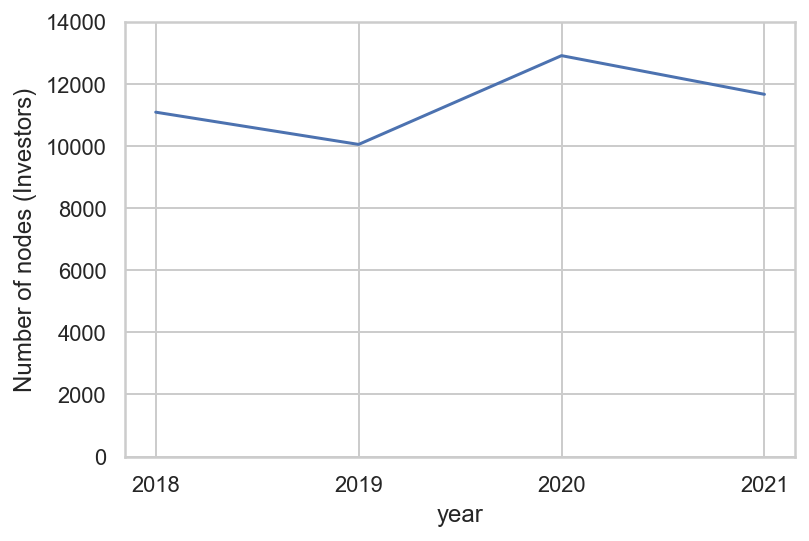

In [64]:
# This is from Margot
plt.plot(years, node_number)
plt.ylim([0, 14000])
plt.xlabel('year')
plt.ylabel('Number of nodes (Investors)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

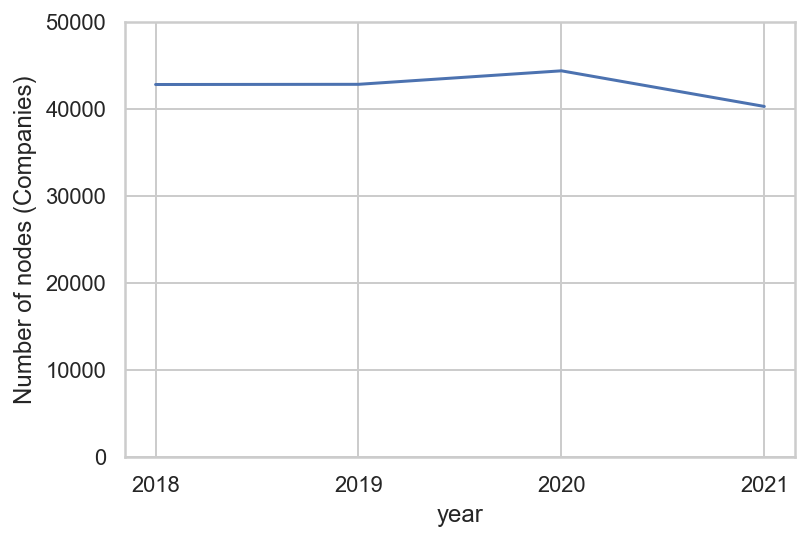

In [65]:
# This is from Margot
plt.plot(years, edge_number)
plt.ylim([0, 50000])
plt.xlabel('year')
plt.ylabel('Number of nodes (Companies)')
plt.show

2. DEGREE : The sum edges of a node. 
In this kind of network, it is easy to find that the nodes with most number of degree will be the invest manager node, below we will find the top 10 investment manager with highest number of companies that it has investment in: 

In [66]:
# An example of degree of all nodes year 2021:
G2021.degree()

[('0000950123', 5240),
 ('0001567619', 4808),
 ('0000948046', 4378),
 ('0001104659', 4041),
 ('0001390777', 3986),
 ('0000914208', 3359),
 ('0000870156', 2252),
 ('0001628280', 2130),
 ('0001137774', 2127),
 ('0001126328', 2119),
 ('0000873630', 2054),
 ('0000038777', 1298),
 ('0001140022', 918),
 ('0001085146', 900),
 ('0000930413', 267),
 ('0001341748', 168),
 ('0001172036', 106),
 ('0001580642', 56),
 ('0001779453', 25),
 ('PFIZER INC', 18),
 ('0001512145', 17),
 ('APPLE INC', 17),
 ('JOHNSON & JOHNSON', 17),
 ('MICROSOFT CORP', 17),
 ('3M CO', 16),
 ('ABBVIE INC', 16),
 ('ALTRIA GROUP INC', 16),
 ('AT&T INC', 16),
 ('CITIGROUP INC', 16),
 ('CSX CORP', 16),
 ('CVS HEALTH CORP', 16),
 ('EBAY INC', 16),
 ('EXXON MOBIL CORP', 16),
 ('HP INC', 16),
 ('INTEL CORP', 16),
 ('MORGAN STANLEY', 16),
 ('ORACLE CORP', 16),
 ('PEPSICO INC', 16),
 ('ROSS STORES INC', 16),
 ('S&P GLOBAL INC', 16),
 ('STARBUCKS CORP', 16),
 ('TARGET CORP', 16),
 ('AMGEN INC', 15),
 ('CONOCOPHILLIPS', 15),
 ('EXELON

In [67]:
#print only "Top 10 nodes by degree"
#get 10 items from output list of function degree()
topManager2018 = (graphs[0].degree())[:10]
topManager2019 = (graphs[1].degree())[:10]
topManager2020 = (graphs[2].degree())[:10]
topManager2021 = (graphs[3].degree())[:10]
company_name2018 = name[0]
company_name2019 = name[1]
company_name2020 = name[2]
company_name2021 = name[3]
top2018=[]
top2019=[]
top2020=[]
top2021=[]
for i in range(10):
    top2018.append(company_name2018.get(topManager2018[i][0])) 
    top2019.append(company_name2019.get(topManager2019[i][0])) 
    top2020.append(company_name2020.get(topManager2020[i][0])) 
    top2021.append(company_name2021.get(topManager2021[i][0])) 
table1 = pd.DataFrame({'Top 2018':top2018,'Top 2019':top2019,'Top 2020':top2020,'Top 2021': top2021})
table1

,Top 2018,Top 2019,Top 2020,Top 2021
0,MORGAN STANLEY,MORGAN STANLEY,MORGAN STANLEY,UBS Group AG
1,DEUTSCHE BANK AG,WELLS FARGO,ROYAL BANK OF CANADA,ROYAL BANK OF CANADA
2,Bank of New York Mellon Corp,DEUTSCHE BANK AG,WELLS FARGO,DEUTSCHE BANK AG
3,JPMORGAN CHASE,Bank of New York Mellon Corp,VANGUARD GROUP INC,VANGUARD GROUP INC
4,GOLDMAN SACHS GROUP INC,VANGUARD GROUP INC,Bank of New York Mellon Corp,Bank of New York Mellon Corp
5,Invesco Ltd,JPMORGAN CHASE,GOLDMAN SACHS GROUP INC,Invesco Ltd
6,CREDIT SUISSE AG,Invesco Ltd,BNP PARIBAS ARBITRAGE,QUADRANT CAPITAL GROUP LLC
7,QUADRANT CAPITAL GROUP LLC,BNP PARIBAS ARBITRAGE,Invesco Ltd,MetLife Investment Management
8,PRUDENTIAL FINANCIAL INC,PRINCIPAL FINANCIAL GROUP INC,QUADRANT CAPITAL GROUP LLC,PRUDENTIAL FINANCIAL INC
9,PRINCIPAL FINANCIAL GROUP INC,FEDERATED INVESTORS INC,PRUDENTIAL FINANCIAL INC,PRINCIPAL FINANCIAL GROUP INC


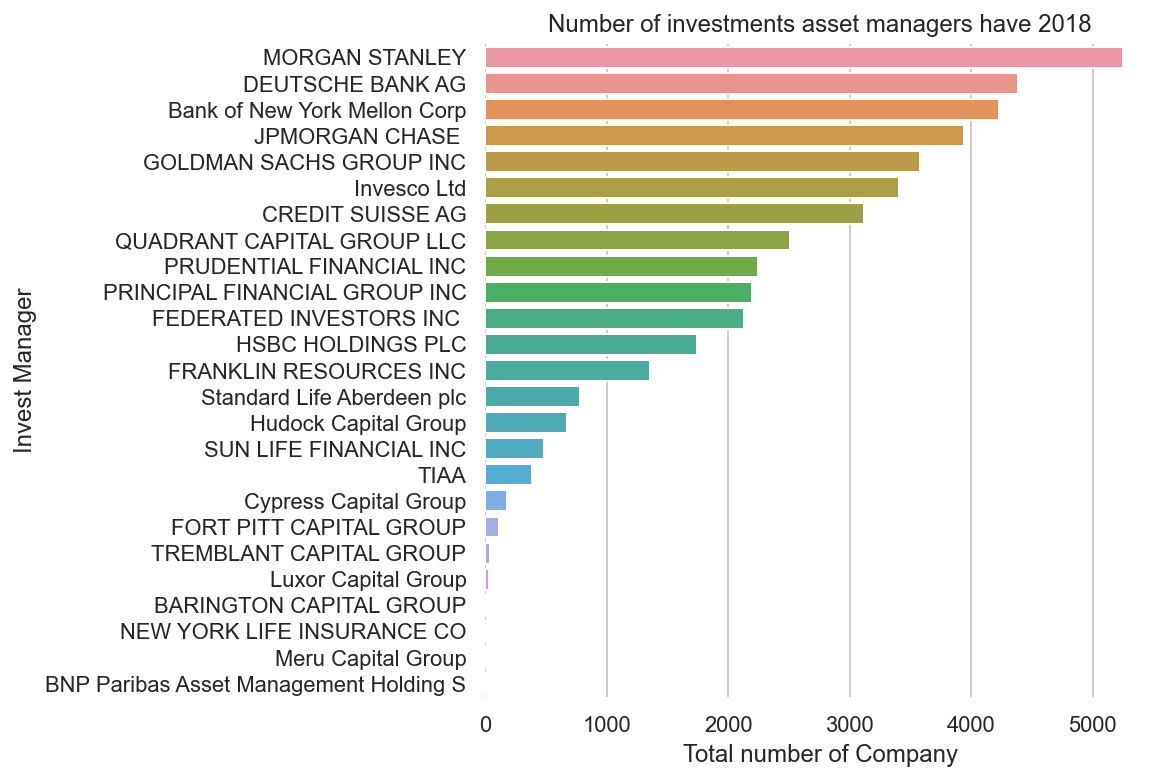

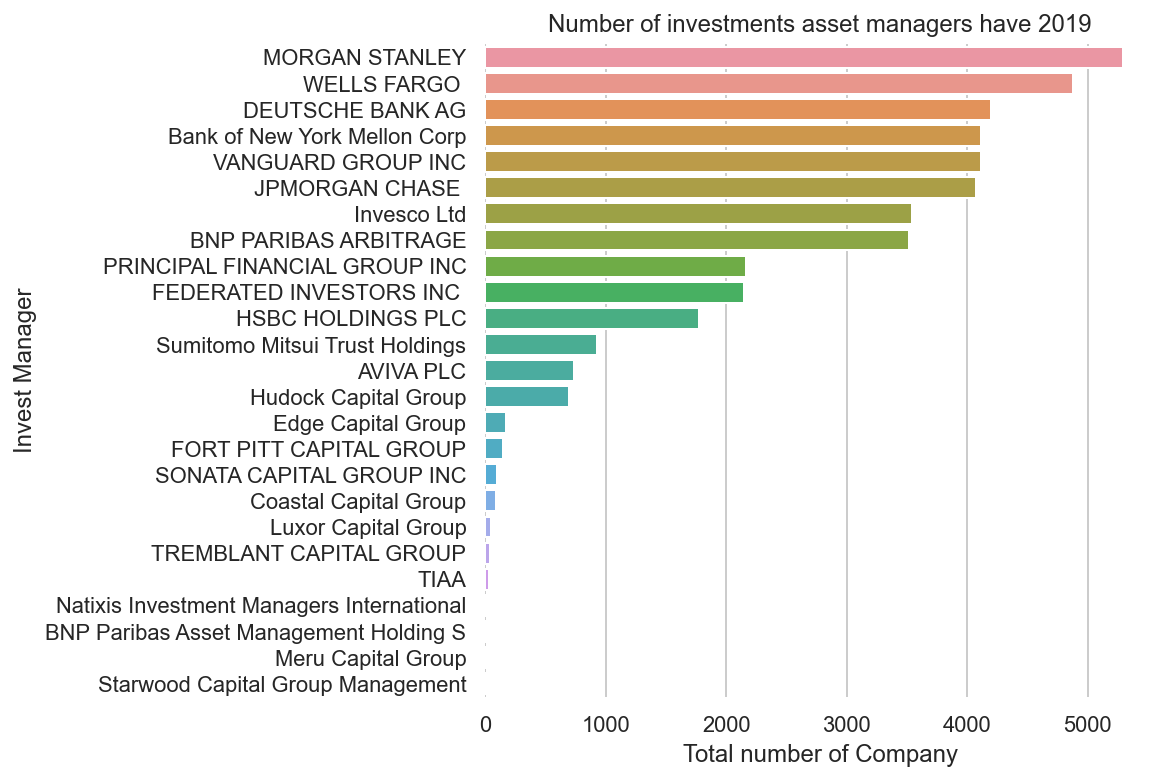

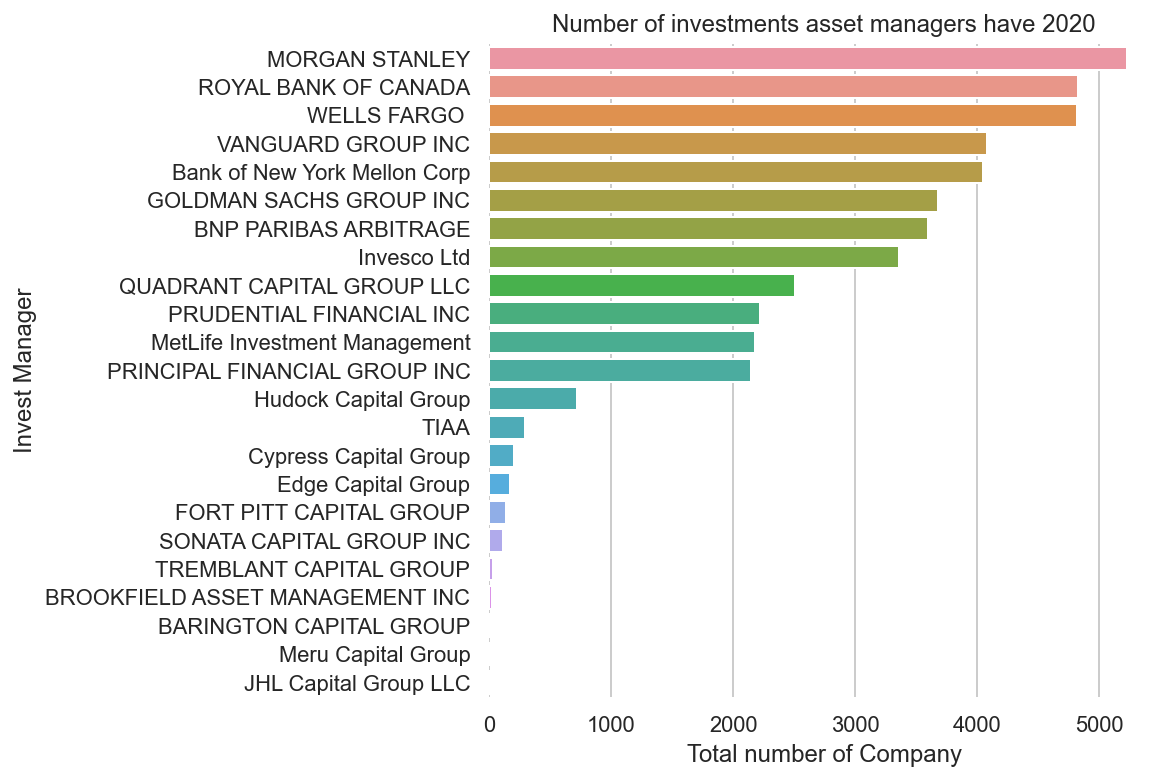

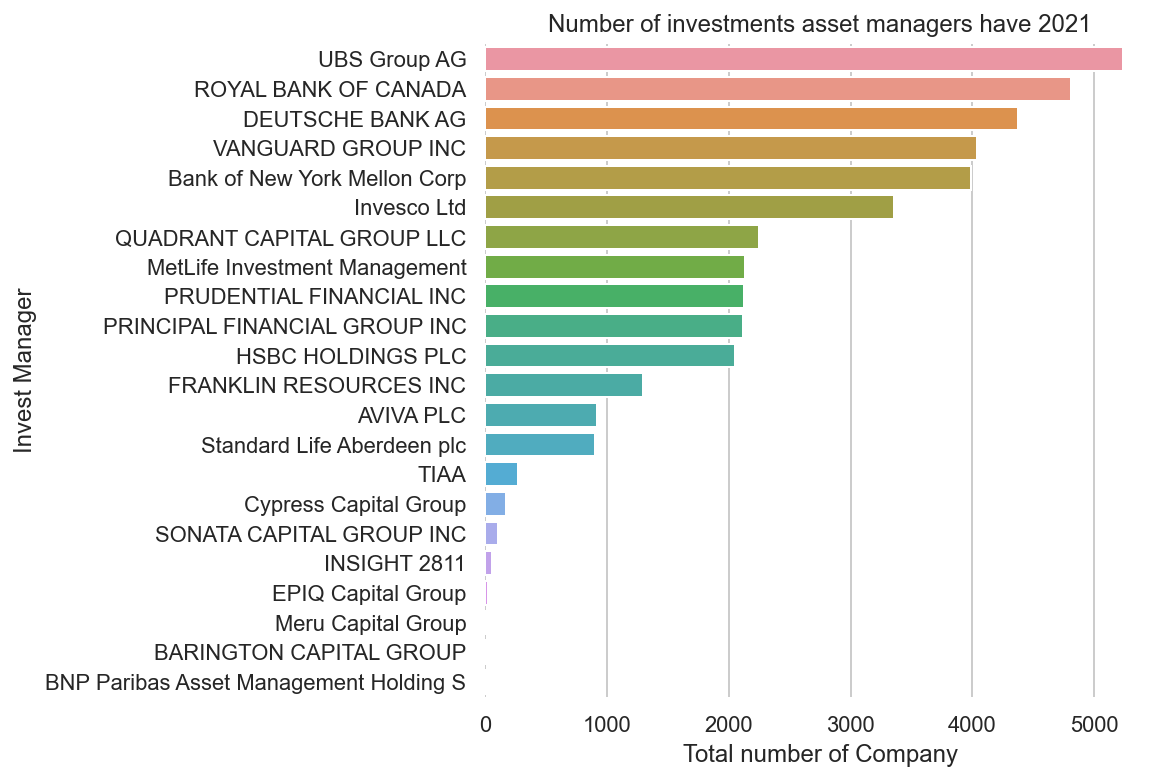

In [68]:
#Visualization: 
for i in range(len(years)):
    df = pd.DataFrame(list(graphs[i].investManager_totalCompany.items()), columns = ['Invest Manager', 'Total number of Company'])
    df= df.sort_values('Total number of Company', ascending = False)

    sns.set_style(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.set_color_codes("pastel")
    sns.barplot(x= 'Total number of Company', y= 'Invest Manager', data = df)
    sns.despine(left=True, bottom=True)
    plt.xlabel('Total number of Company')
    plt.ylabel('Invest Manager')
    plt.title('Number of investments asset managers have ' + years[i])

3. NODE SIMILARITY: the number of shared nodes in other partition between 2 nodes of the same partition

NODE SIMILARITY of 2 investmentManagers : the number of shared companies that they both having investment in. With large number of shared assets, two investmentManger can have the similar degree of business. Two huge investmentManagers have more mutual investments (tendency), compare the stock value of mutual assets can give a clearer insight into their business.

NODE SIMILARITY of 2 Companies: the number of shared investmentManagers that invest on both of them. 

In [69]:
# Interest on the number of shared companies between 2 investments: 
# Get all manager_pair of year 2021 for a demo:
manager_pair2021 = list(combinations(G2021.manager_nodes,2))
# Define a function to visualize in table, a pair of node has largest number of shared companies: 
def shared_partition_table(Graph,listOfPair):
    score =[]
    ele1=[]
    ele2=[]
    for pair in listOfPair:
        ele1.append(pair[0])
        ele2.append(pair[1])
        score.append(Graph.shared_partition_nodes(pair[0],pair[1]))
        shared_company_table = pd.DataFrame({'Node 1':ele1, 'Node 2':ele2, 'Number of shared nodes':score})
    return shared_company_table.sort_values('Number of shared nodes', ascending = False)

shared_partition_table(G2021,manager_pair2021)

,Node 1,Node 2,Number of shared nodes
1,0000950123,0001567619,4630
15,0000950123,0001104659,3843
54,0001567619,0001104659,3699
7,0000950123,0000948046,3465
46,0001567619,0000948046,3348
...,...,...,...
73,0001615774,0001126328,0
90,0001520354,0001126328,0
91,0001520354,0001137774,0
92,0001520354,0000870156,0


In [70]:
#Get number of shared companies between MORGAN STANLEY 0000895421 & WELLS FARGO 0000072971
G2021.shared_partition_nodes('0000895421','0000072971')
# 2 most powerful investors also share the most number of nodes

KeyError: '0000895421'

4. NODE DISSIMILARITY: the number/list of nodes that belong to one node but not in another node. 

DISSIMILARITY of 2 investmentManagers : => Recommendation on new investment or insight into competitors investment
DISSIMILARITY of 2 Companies: not so intuitive

In [18]:
# Nodes that has most different common company shares: 
def diff_partition_table(Graph,listOfPair):
    score =[]
    ele1=[]
    ele2=[]
    for pair in listOfPair:
        ele1.append(pair[0])
        ele2.append(pair[1])
        score.append(Graph.diff_partition_nodes(pair[0],pair[1]))
        diff_company_table = pd.DataFrame({'Node 1':ele1, 'Node 2':ele2, 'Number of nodes belong to node1 but not node2':score})
    return diff_company_table.sort_values('Number of nodes belong to node1 but not node2', ascending = False)

diff_partition_table(G2021,manager_pair2021)

,Node 1,Node 2,Number of nodes belong to node1 but not node2
2,0000950123,0001615774,5240
3,0000950123,0001520354,5240
19,0000950123,0001172036,5229
13,0000950123,0001512145,5223
8,0000950123,0001779453,5215
...,...,...,...
79,0001520354,0001085146,1
78,0001520354,0001390777,1
80,0001520354,0001341748,1
205,0001512145,0001126328,0


5. INVOLVING EDGE WEIGHT

Edge weight is defined as the stock amount investing in each company: ('0000950123', '10X GENOMICS INC', {'amount': 174263})

Calculate the total investment can define a subgroup of investManager that have the highest amount of asset for further analysis

Using edge weight to define the distance of investmentManage-company edge in visualization (???)

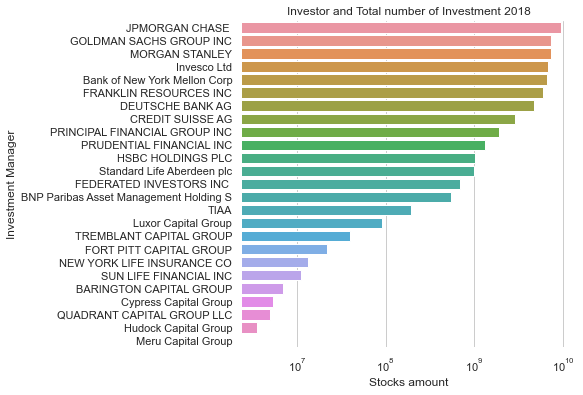

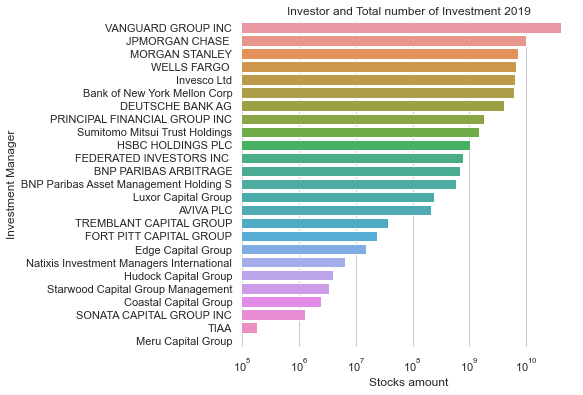

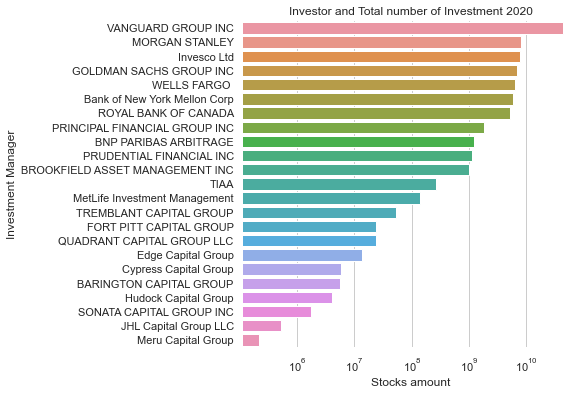

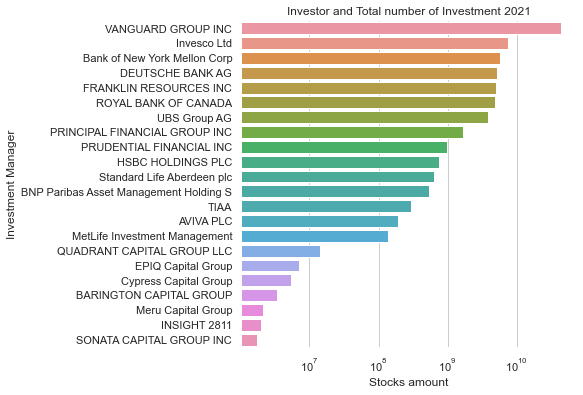

In [19]:
#Visualization
df_total = []
for i in range(len(years)):
    df = pd.DataFrame(list(graphs[i].investManager_totalInvestment.items()), columns = ['Investment Manager', 'total Investment/stock'])
    df = df.sort_values('total Investment/stock', ascending = False)
    df_total.append(df)
   
    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.set_color_codes("pastel")
    g = sns.barplot(x= 'total Investment/stock', y= 'Investment Manager', data = df)
    g.set_xscale('log')
    sns.despine(left=True, bottom=True)
    plt.xlabel('Stocks amount')
    plt.ylabel('Investment Manager')
    plt.title('Investor and Total number of Investment ' + years[i])

6. SUBGRAPH

Sometimes it is important to just analyze a subset of nodes in a network (aka. the top 10 most influent investManager).

In [20]:
# InvestmentManager that has both "higest Stock" and "hihgest number of Company connection"
tb=[]
A=[]
for i in range(len(years)):
    df1 = pd.DataFrame(list(graphs[i].investManager_totalCompany.items()), columns = ['Invest Manager', 'Total number of Company'])
    df1= df1.sort_values('Total number of Company', ascending = False)
    df2 = pd.DataFrame(list(graphs[i].investManager_totalInvestment.items()), columns = ['Investment Manager', 'total Investment/stock'])
    df2 = df2.sort_values('total Investment/stock', ascending = False)
   
    df = pd.concat([df1, df2['total Investment/stock']], axis=1)
    df = df.sort_values(["Total number of Company", "total Investment/stock"], ascending = (False, False))
    a = df.head(10)['Invest Manager']
    A.append(a)
    b = df.head(10)['Total number of Company']
    c =df.head(10)['total Investment/stock']
    tb.append(pd.DataFrame({'Invest Manager':a,'Total number of Company':b,'Total stock':c}))
# Print for year 2021
tb[3]
#tb[3].style.set_properties(**{'text-align': 'center'})

,Invest Manager,Total number of Company,Total stock
0,UBS Group AG,5240,3901354508
2,ROYAL BANK OF CANADA,4808,4916368547
8,DEUTSCHE BANK AG,4378,5236224989
16,VANGUARD GROUP INC,4041,44373946612
5,Bank of New York Mellon Corp,3986,5714654979
13,Invesco Ltd,3359,7569993390
19,QUADRANT CAPITAL GROUP LLC,2252,14146831
15,MetLife Investment Management,2130,138919834
18,PRUDENTIAL FINANCIAL INC,2127,974267229
17,PRINCIPAL FINANCIAL GROUP INC,2119,1697524914


In [21]:
# Get subgroup CIK subgraph
subgroup1=[]
for name in A[3]:
    for cik, n in graphs[3].names_dict.items():
        if name == n:
            subgroup1.append(cik)
            
subgroup1

['0000950123',
 '0001567619',
 '0000948046',
 '0001104659',
 '0001390777',
 '0000914208',
 '0000870156',
 '0001628280',
 '0001137774',
 '0001126328']

# margot:  ANALYSIS over time

- NETWORK DENSITY # Duplicate
- degree of centrality
- closeness_centrality
- betweenness_centrality

## Degree of centrality:  the ratio of (number of connected nodes)/(total number of the opposite partition nodes)
Number of connections (known as degree) of each node

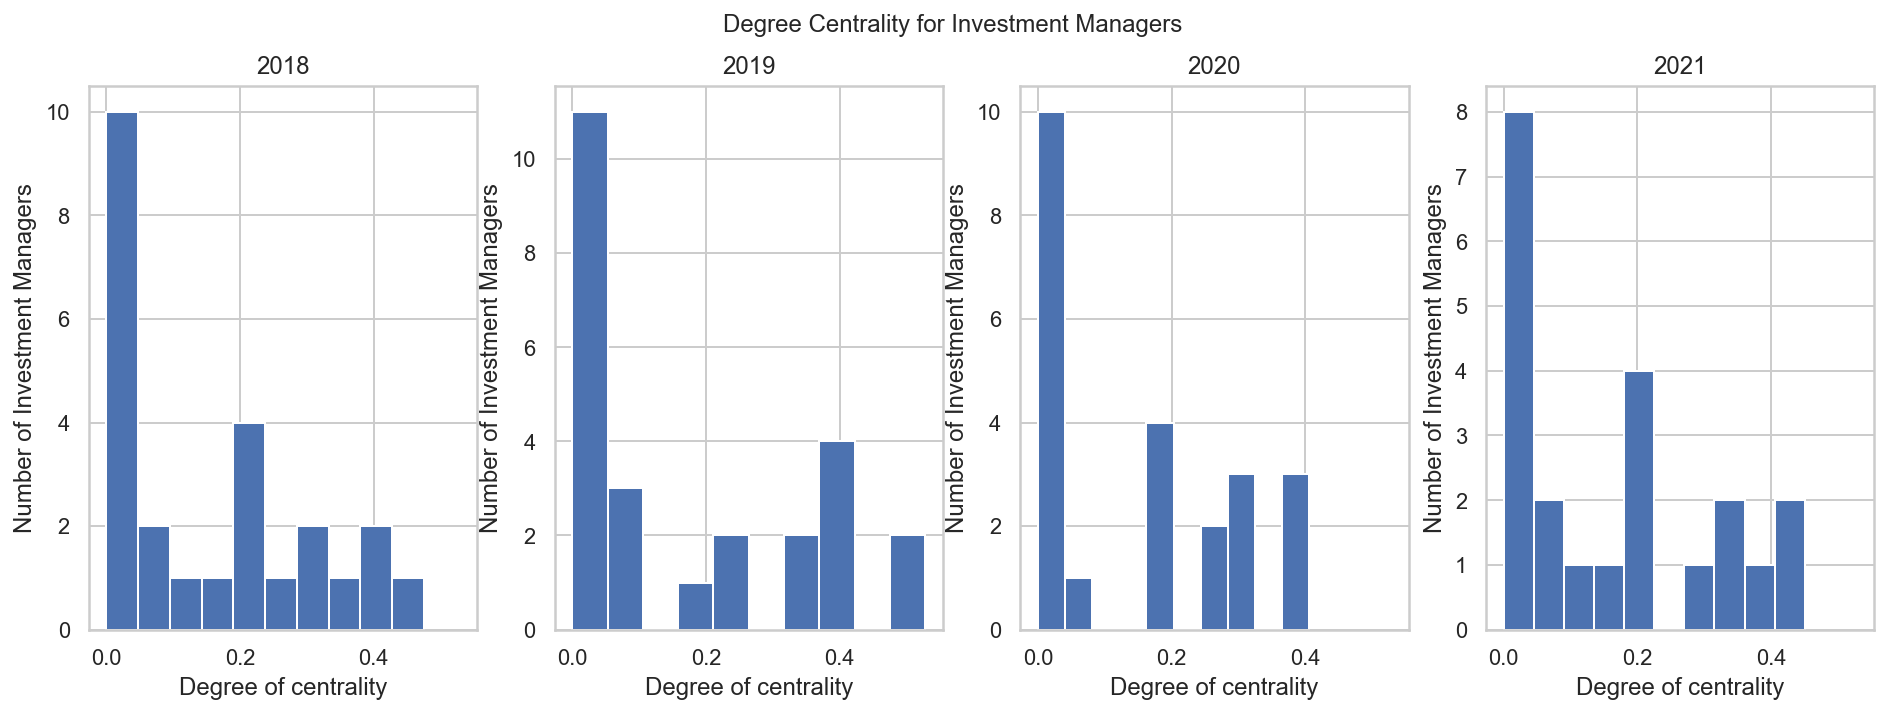

In [73]:
# Calculate degree centrality for Investors:

#Margot way:
densities_1 = []
for i in graphs:
    densities_1.append(i.degreeCentralityM())

#Visualize:
fig, axes = plt.subplots(1, len(years), sharex=True, figsize=(16,5))
fig.suptitle('Degree Centrality for Investment Managers')
for i in range(len(years)):
    axes[i].set_title(years[i])
    axes[i].hist(densities_1[i])
    axes[i].set_xlabel("Degree of centrality")
    axes[i].set_ylabel("Number of Investment Managers")


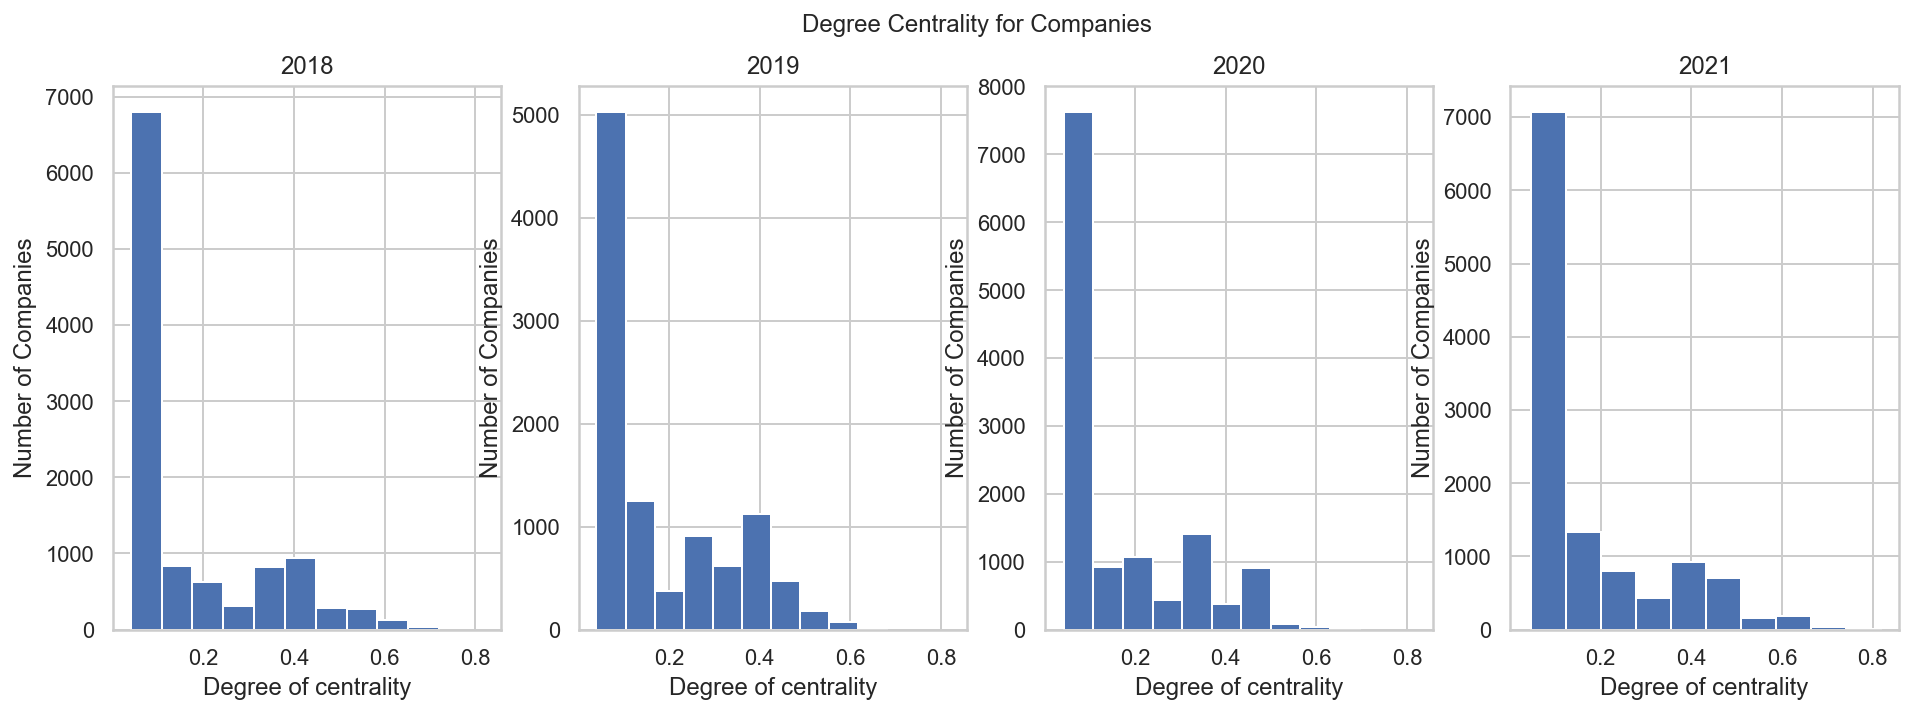

In [74]:
# Calculate degree centrality for company:
#Margot way:
densities_2 = []
for i in graphs:
    densities_2.append(i.degreeCentralityC())

#Visualize:
fig, axes = plt.subplots(1, len(years), sharex=True, figsize=(16,5))
fig.suptitle('Degree Centrality for Companies')
for i in range(len(years)):
    axes[i].set_title(years[i])
    axes[i].hist(densities_2[i])
    axes[i].set_xlabel("Degree of centrality")
    axes[i].set_ylabel("Number of Companies")

## closeness_centrality
Compute the closeness centrality for nodes in a bipartite network. This a method to detect those nodes that are able to spread information throughout the network.It represents the distance of a node (Company or Manager) to all the other nodes in the graph.

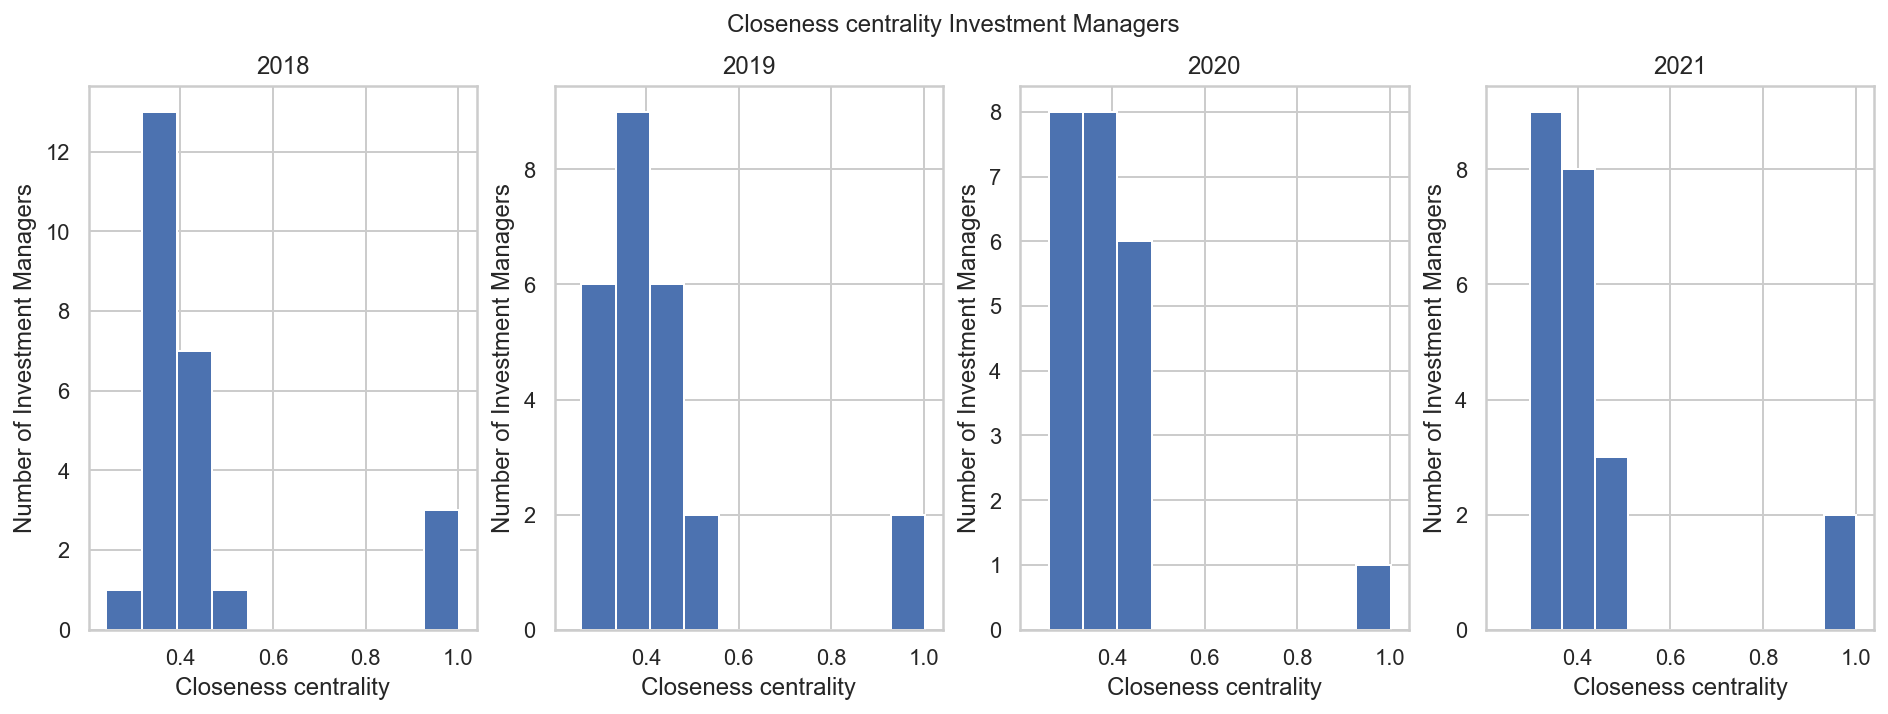

In [71]:
#Margot way:
closeness_1 = []
for i in graphs:
    closeness_1.append(i.closenessCentralityM())

#Visualize:
fig, axes = plt.subplots(1, len(years), sharex=True, figsize=(16,5))
fig.suptitle('Closeness centrality Investment Managers')
for i in range(len(years)):
    axes[i].set_title(years[i])
    axes[i].hist(closeness_1[i])
    axes[i].set_xlabel("Closeness centrality")
    axes[i].set_ylabel("Number of Investment Managers")

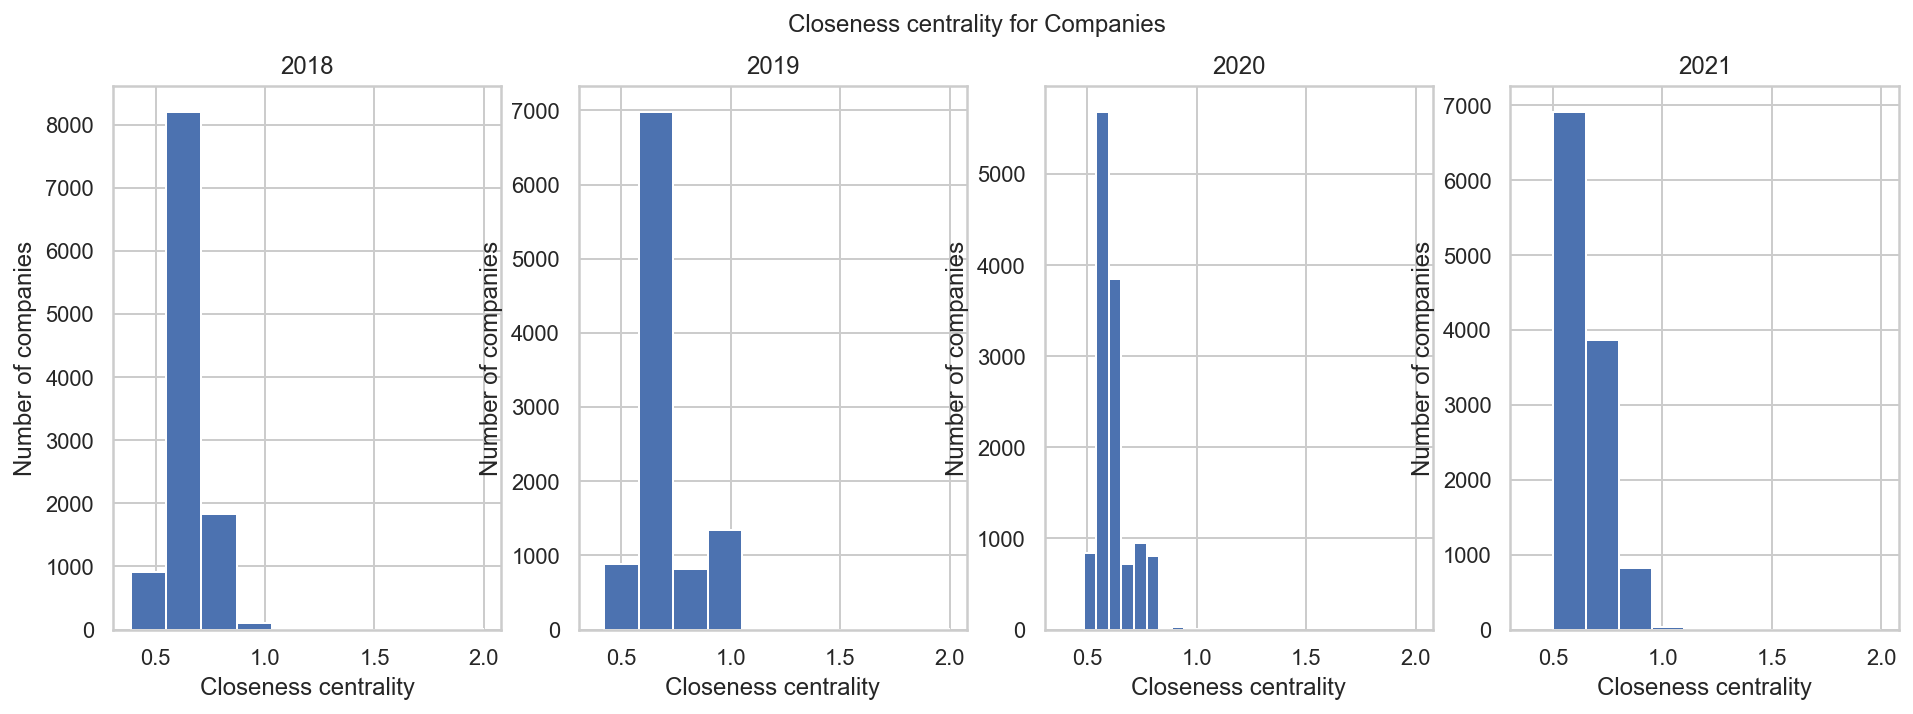

In [72]:
# Calculate closeness centrality for Company:

#Margot way:
closeness_2 = []
for i in graphs:
    closeness_2.append(i.closenessCentralityC())

#Visualize:
fig, axes = plt.subplots(1, len(years), sharex=True, figsize=(16,5))
fig.suptitle('Closeness centrality for Companies')
for i in range(len(years)):
    axes[i].set_title(years[i])
    axes[i].hist(closeness_2[i])
    axes[i].set_xlabel("Closeness centrality")
    axes[i].set_ylabel("Number of companies")

## betweenness_centrality
Compute betweenness centrality for nodes in a bipartite network.
slides: The Betweenness Centrality algorithm first calculates the shortest (weighted) path between every pair of nodes in a connected graph. Each node receives a score, based on the number of these shortest paths that pass through the node. The more shortest paths that a node lies on, the higher its score.

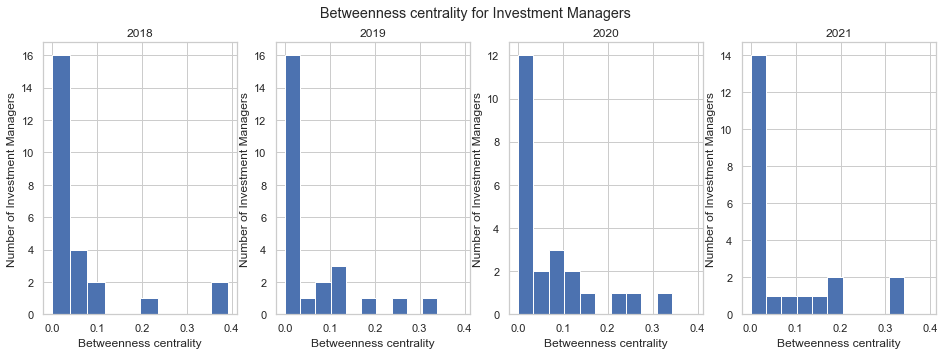

In [22]:
#Margot way:
betweenness_1 = []
for i in graphs:
    betweenness_1.append(i.betweennessCentralityM())

#Visualize:
fig, axes = plt.subplots(1, len(years), sharex=True, figsize=(16,5))
fig.suptitle('Betweenness centrality for Investment Managers')
for i in range(len(years)):
    axes[i].set_title(years[i])
    axes[i].hist(betweenness_1[i])
    axes[i].set_xlabel("Betweenness centrality")
    axes[i].set_ylabel("Number of Investment Managers")

In [48]:
len(betweenness_1[0])

25

In [44]:
indexTop10_BcM = np.argsort(betweenness_1[0])[:-10]
indexTop10_BcM

array([ 2, 18,  1, 16, 14,  8, 20,  4,  5,  9, 11, 21, 22, 19,  7],
      dtype=int64)

In [30]:
len(betweenness_1[2])

23

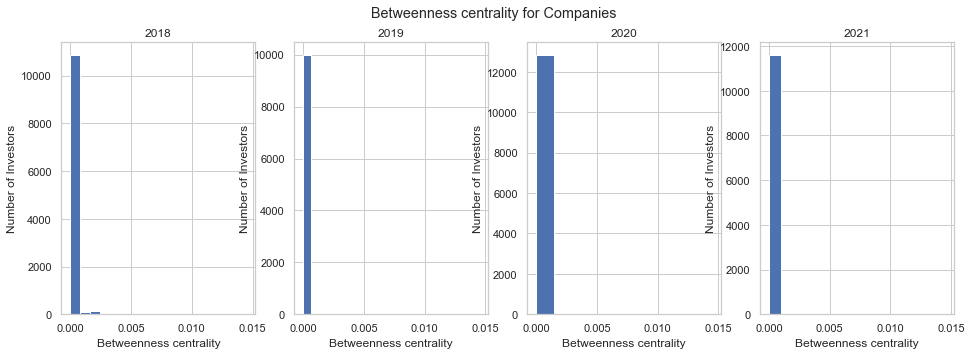

In [47]:
# Calculate Betweenness centrality for Companies:

#Margot way:
betweenness_2 = []
for i in graphs:
    betweenness_2.append(i.betweennessCentralityC())

#Visualize:
fig, axes = plt.subplots(1, len(years), sharex=True, figsize=(16,5))
fig.suptitle('Betweenness centrality for Companies')
for i in range(len(years)):
    axes[i].set_title(years[i])
    axes[i].hist(betweenness_2[i])
    axes[i].set_xlabel("Betweenness centrality")
    axes[i].set_ylabel("Number of Investors")

In [49]:
len(betweenness_2[0])

11063

In [50]:
len(betweenness_2[1])

10025

# VISUALISATION over time

## Spaghettiplot

In [ ]:
#merge dataframes, made in the analysis
def merge_table(table_list):
        result = table_list[0].merge(table_list[1],on='Investment Manager', how='outer').fillna(0)
        i=2
        while i<len(table_list):
            result = result.merge(table_list[i],on='Investment Manager', how='outer').fillna(0)
            i=i+1
        return result
    

In [ ]:
total_over_years = merge_table(df_total)
#rename the columns
total_over_years.columns = ["Investment Manager", "2018", "2019", "2020","2021"]

In [ ]:
df_10_H_Cik = total_over_years.nlargest(10, '2021') #take only the highest 10 investmentmanagers 
trans = df_10_H_Cik.set_index('Investment Manager').T #transpose of the dataframe
trans2 = test2.set_index('Investment Manager').T #with all the investmentmanagers

### Spaghettiplot over time for top 10 investment managers

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme()
sns.set_style("ticks")

In [ ]:
sns.relplot(data = trans, kind="line", height = 8)
plt.title('Plot over time')
# Set x-axis label
plt.xlabel('years')
# Set y-axis label
plt.ylabel('Total amount of stock per Investment Manager')

### Spaghettiplot over time for all investment managers

In [ ]:
sns.relplot(data = trans2, kind="line", height = 8)

## Networks

In [ ]:
df_network = []
for i in range(len(years)):
    df = pd.DataFrame.from_dict(data[i],orient='index', ).stack().reset_index()
    df.columns=['CIK','issuer','amount']
    df_network.append(df)

In [ ]:
def making_graphs(dataframe_year):
    G = nx.from_pandas_edgelist(dataframe_year, source='CIK', 
                            target = 'issuer', 
                            edge_attr='amount')
    return G

In [ ]:
graphs_visualisation = []
for x in df_network:
    graphs_visualisation.append(making_graphs(x))

In [ ]:
def make_network_important(G, df):
    cik, issuer = bipartite.sets(G, df['CIK'])
    remove1 = [node for node,degree in dict(G.degree(issuer)).items() if (degree <=15)]
    G.remove_nodes_from(remove1)
    remove2 = [node for node,degree in dict(G.degree(cik)).items() if (degree ==0)]
    G.remove_nodes_from(remove2)
    cik1, issuer1 = bipartite.sets(G, df['CIK'])
    cikDegree = G.degree(cik1)
    issuerDegree = G.degree(issuer1)
    cik3 = [n for n,value in cikDegree]
    issuer3 = [n for n,value in issuerDegree]
    
    #make plot
    pos=nx.spring_layout(G) # positions for all nodes

    plt.figure(2,figsize=(15,15)) 
    plt.axis('off')
    #nodes
    nx.draw_networkx_nodes(G,pos,
                           nodelist=cik3,
                           node_color='r',
                           node_size= [v * 20 for v in dict(cikDegree).values()],
                            alpha = 0.8)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=issuer3,
                           node_color='b',
                           node_size= [v * 10 for v in dict(issuerDegree).values()],
                           alpha = 0.6)
    #edges
    nx.draw_networkx(G,pos,width=1, alpha = 1, node_size= 0, font_size = 8)

### Network 2018 

In [ ]:
make_network_important(graphs_visualisation[0], df_network[0])

### Network 2019 

In [ ]:
make_network_important(graphs_visualisation[1], df_network[1])

### Network 2020

In [ ]:
make_network_important(graphs_visualisation[2], df_network[2])

### Network 2021

In [ ]:
make_network_important(graphs_visualisation[3], df_network[3])